# Spreading and subduction rates

For this notebook we import `PlateTectonicTools`, a series of functions that conveniently queries spreading rates and convergence kinematics. The way it does this is by tesselating topologies that are marked as a "SubductionZone" or "MidOceanRidge" into small segments. From there it extracts the velocity vector of the plates on either side of that boundary and returns kinematic information.

#### Mid-ocean ridges

- Location of mid-ocean ridges segments
- Spreading rate (cm/yr)
- Length of each arc segment (degrees)

#### Trenches

- Location of trench segments
- Convergence velocity (cm/yr)
- Convergence angle (angle between trench normal vector and convergence velocity vector)
- Trench absolute velocity (relative to anchor plate) (cm/yr)
- Trench obliquity angle (angle between trench normal and trench absolute velocity)
- Length of each arc segment (degrees)
- Trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees)
- Subducting plate ID
- Trench plate ID

In [1]:
import numpy as np
import pygplates
import ptt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

In [2]:
# location of files we want to use
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'
static_polygon_file = 'Data/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.gpmlz'
coastline_filename = 'Data/Global_EarthByte_GPlates_PresentDay_Coastlines.gpmlz'
topology_filename = "Data/Muller2019-Young2019-Cao2020_PlateBoundaries.gpmlz"

# read into pygplates
rotation_model = pygplates.RotationModel(rotation_filename)
static_polygons = pygplates.FeatureCollection(static_polygon_file)
coastlines = pygplates.FeatureCollection(coastline_filename)
topology_features = pygplates.FeatureCollection(topology_filename)

tessellation_threshold_radians = np.deg2rad(0.5)

In [13]:
reconstruction_time = 0

# calculate subduction convergence
subduction_data = ptt.subduction_convergence.subduction_convergence(
    rotation_model,
    topology_features,
    tessellation_threshold_radians,
    reconstruction_time,
    velocity_delta_time=1,
    anchor_plate_id=0)
subduction_data = np.vstack(subduction_data)

subduction_lon     = subduction_data[:,0]
subduction_lat     = subduction_data[:,1]
subduction_angle   = subduction_data[:,3]
subduction_norm    = subduction_data[:,7]
subduction_pid_sub = subduction_data[:,8]
subduction_pid_over= subduction_data[:,9]
subduction_length  = np.radians(subduction_data[:,6]) * pygplates.Earth.mean_radius_in_kms * 1e3 # in metres
subduction_convergence = subduction_data[:,2]*1e-2 * np.cos(np.radians(subduction_data[:,3]))
subduction_migration   = subduction_data[:,4]*1e-2 * np.cos(np.radians(subduction_data[:,5]))

# calculate spreading rate
ridge_data = ptt.ridge_spreading_rate.spreading_rates(
    rotation_model,
    topology_features,
    reconstruction_time,
    tessellation_threshold_radians,
    [pygplates.FeatureType.gpml_mid_ocean_ridge],
    anchor_plate_id=0)
ridge_data = np.vstack(ridge_data)

ridge_lon    = ridge_data[:,0]
ridge_lat    = ridge_data[:,1]
ridge_vel    = ridge_data[:,2] * 1e-2
ridge_length = np.radians(ridge_data[:,3]) * pygplates.Earth.mean_radius_in_kms * 1e3

/Users/ben/miniforge3/envs/mapping/lib/python3.9/site-packages/ptt/subduction_convergence.py:358: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Izu Bonin Trench" at 0.0Ma.
    Either the subduction polarity is not properly set or there is not exactly one subducting plate sharing the sub-segment.
    Ignoring current sub-segment.
  warnings.warn('Unable to find the subducting plate of the subducting sub-segment "{0}" at {1}Ma.\n'
/Users/ben/miniforge3/envs/mapping/lib/python3.9/site-packages/ptt/subduction_convergence.py:358: RuntimeWarning: Unable to find the subducting plate of the subducting sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 0.0Ma.
    Either the subduction polarity is not properly set or there is not exactly one subducting plate sharing the sub-segment.
    Ignoring current sub-segment.
  warnings.warn('Unable to find the subducting plate of the subducting sub-segment "{0}" at {1}Ma.\n'
/Users/ben/miniforge3/en

Reconstruct coastlines (to the present day, in this case!)

In [8]:
# --- Save ouput file as a shapefile (instead of saving it to an empty list)
output_reconstructed_feature_filename = 'reconstructed_coastlines.shp'

# Use pygplates to carry out the reconstruction 
pygplates.reconstruct(coastline_filename,
                      rotation_filename,
                      output_reconstructed_feature_filename,
                      reconstruction_time,
                      anchor_plate_id=0)

shp_coast = shpreader.Reader(output_reconstructed_feature_filename)
ft_coast = cfeature.ShapelyFeature(shp_coast.geometries(), crs=ccrs.PlateCarree())


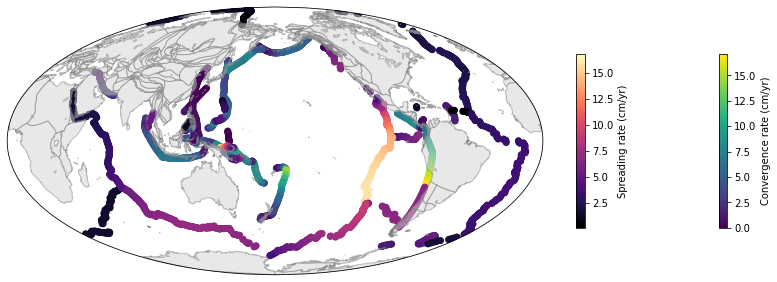

In [14]:
proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

sz  = ax.scatter(subduction_lon, subduction_lat, c=subduction_convergence*100,
                 cmap='viridis', transform=ccrs.PlateCarree())
mor = ax.scatter(ridge_lon, ridge_lat, c=ridge_vel*100,
                 cmap='magma', transform=ccrs.PlateCarree())

ax.add_feature(ft_coast, facecolor='LightGrey', edgecolor='grey', alpha=0.5)
fig.colorbar(sz, shrink=0.4, label='Convergence rate (cm/yr)')
fig.colorbar(mor, shrink=0.4, label='Spreading rate (cm/yr)')

We have all the ingredients to compute the rate of crustal production vs. crustal destruction

In [18]:
# Area subducted by trenches over 1 year (km^2/yr)
destruction_area = np.sum(subduction_convergence * subduction_length) * 1e-6

# Area produced by mid-ocean ridges over 1 year (km^2/yr)
production_area = np.sum(ridge_vel * ridge_length) * 1e-6

print("destruction rate = {:.2f} km^2/yr".format(destruction_area))
print("production rate = {:.2f} km^2/yr".format(production_area))

print("ratio of production to destruction = {:.2f}".format(production_area/destruction_area))

destruction rate = 2.50 km^2/yr
production rate = 3.17 km^2/yr
ratio of production to destruction = 1.27


In [6]:
## Exercise - plot the mean spreading rate and convergence rate over the last 100 million years!